In [ ]:
# 필요한 라이브러리 설치
!pip install pandas numpy scikit-learn joblib matplotlib seaborn

# Colab 환경에서 Kaggle API 사용을 위한 준비
!pip install kaggle

In [ ]:
from google.colab import files

# kaggle.json 파일 업로드 창이 열립니다.
files.upload()

# 업로드된 파일을 .kaggle 폴더로 이동 및 권한 설정
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

KeyboardInterrupt: 

In [ ]:
# 데이터셋 다운로드 및 압축 해제
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

# 데이터프레임 로드
import pandas as pd
df = pd.read_csv('creditcard.csv')

print("데이터셋 로드 완료:", df.shape)
print("사기 거래 건수:", df['Class'].sum())

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  creditcardfraud.zip
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: creditcard.csv          
데이터셋 로드 완료: (284807, 31)
사기 거래 건수: 492


In [ ]:
# 데이터의 첫 5줄을 출력합니다.
print(df.head())

# 각 컬럼의 정보(데이터 타입, null 값 여부)를 출력합니다.
print(df.info())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
from sklearn.preprocessing import StandardScaler
import joblib

data = df.copy()

# 1. Amount 전용 스케일러
scaler_amount = StandardScaler()
data['Scaled_Amount'] = scaler_amount.fit_transform(data['Amount'].values.reshape(-1, 1))

# 2. Time 전용 스케일러
scaler_time = StandardScaler()
data['Scaled_Time'] = scaler_time.fit_transform(data['Time'].values.reshape(-1, 1))

# 원래 컬럼 제거
data.drop(['Time', 'Amount'], axis=1, inplace=True)

# 2개의 스케일러를 각각 저장
joblib.dump(scaler_amount, 'amount_scaler.pkl')
joblib.dump(scaler_time, 'time_scaler.pkl')

print("-> amount_scaler.pkl, time_scaler.pkl 파일 2개 저장 완료")
print("\n스케일링 후 데이터 확인:")
print(data.head())

-> amount_scaler.pkl, time_scaler.pkl 파일 2개 저장 완료

스케일링 후 데이터 확인:
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

  

In [ ]:
# Z-Score 계산을 위한 V1-V28 피처의 평균, 표준편차 저장
v_features = [f'V{i}' for i in range(1, 29)]
feature_stats = {
    'means': df[v_features].mean().to_dict(),
    'stddevs': df[v_features].std().to_dict()
}

joblib.dump(feature_stats, 'feature_stats.pkl')
print("-> feature_stats.pkl 파일 저장 완료 (V1-V28 평균, 표준편차)")

In [ ]:
# X: 모델이 학습할 피처 (Class 컬럼 제외)
X = data.drop('Class', axis=1)

# y: 정답 레이블 (평가용)
y = data['Class']

print(f"학습 피처 (X) shape: {X.shape}")
print(f"정답 레이블 (y) shape: {y.shape}")

학습 피처 (X) shape: (284807, 30)
정답 레이블 (y) shape: (284807,)


In [ ]:
from sklearn.ensemble import IsolationForest
import joblib # joblib도 import 합니다.

# 1. 사기 거래 비율 계산 (Contamination 값으로 사용)
fraud_ratio = df['Class'].sum() / len(df)
print(f"사기 거래 비율 (Contamination): {fraud_ratio}")

# 2. 모델 초기화
model = IsolationForest(n_estimators=150,
                        contamination=fraud_ratio,
                        random_state=42,
                        n_jobs=-1) # n_jobs=-1 추가: CPU 코어를 모두 사용해 학습 속도 향상

print("\n모델 학습(fit)을 시작합니다...")

# 3. 모델 학습 (X 데이터만 사용!)
model.fit(X)

print("모델 학습 완료!")

# 4. 학습된 모델 파일로 저장 (Phase 2에서 사용할 최종 결과물)
joblib.dump(model, 'fraud_detector.pkl')
print("-> fraud_detector.pkl 모델 파일 저장 완료!")

사기 거래 비율 (Contamination): 0.001727485630620034

모델 학습(fit)을 시작합니다...
모델 학습 완료!
-> fraud_detector.pkl 모델 파일 저장 완료!


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("모델 예측을 시작합니다...")

# 1. 모델 예측 수행 (사기: -1, 정상: 1)
y_pred = model.predict(X)

# 2. 예측 결과 변환 (우리의 'y'와 형식을 맞춤)
# (사기 -1 -> 1, 정상 1 -> 0)
y_pred[y_pred == 1] = 0  # 정상(1)을 0으로
y_pred[y_pred == -1] = 1 # 사기(-1)를 1로

# 3. 예측 결과와 실제 정답 비교
print("\n--- 모델 성능 평가 ---")
print(f"실제 사기 건수 (y=1): {np.sum(y)}")
print(f"모델이 예측한 사기 건수: {np.sum(y_pred)}")

# 4. 성능 리포트 출력 (Precision, Recall, F1-score)
# '1' (사기) 클래스의 'recall' 값을 주목하세요.
print("\n[Classification Report]")
print(classification_report(y, y_pred, target_names=['Class 0 (Normal)', 'Class 1 (Fraud)']))

모델 예측을 시작합니다...

--- 모델 성능 평가 ---
실제 사기 건수 (y=1): 492
모델이 예측한 사기 건수: 492

[Classification Report]
                  precision    recall  f1-score   support

Class 0 (Normal)       1.00      1.00      1.00    284315
 Class 1 (Fraud)       0.26      0.26      0.26       492

        accuracy                           1.00    284807
       macro avg       0.63      0.63      0.63    284807
    weighted avg       1.00      1.00      1.00    284807



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

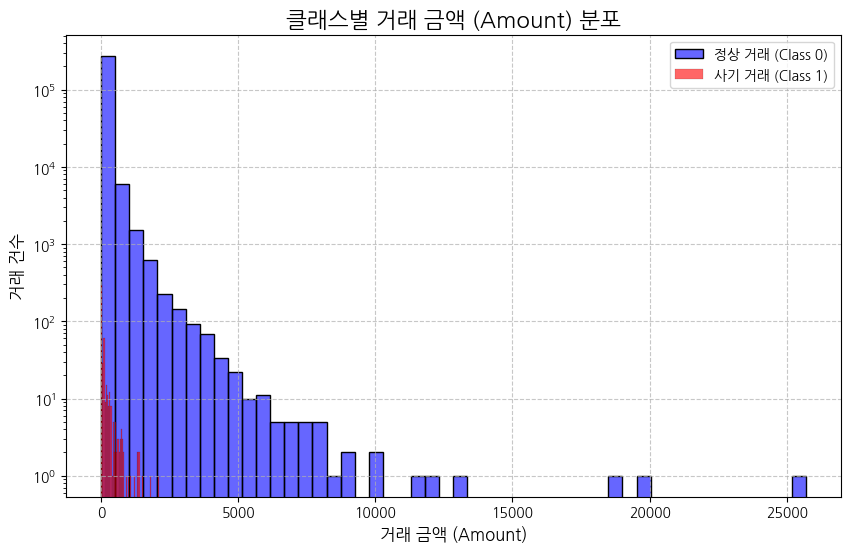

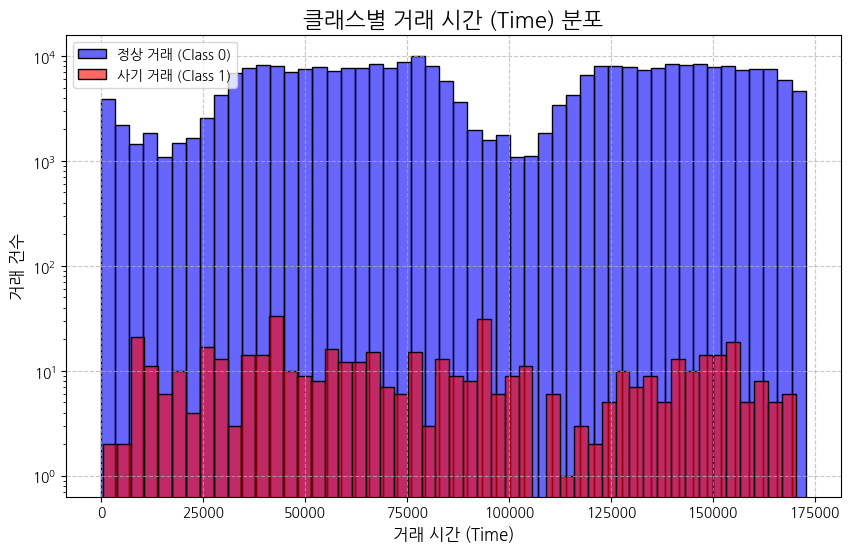

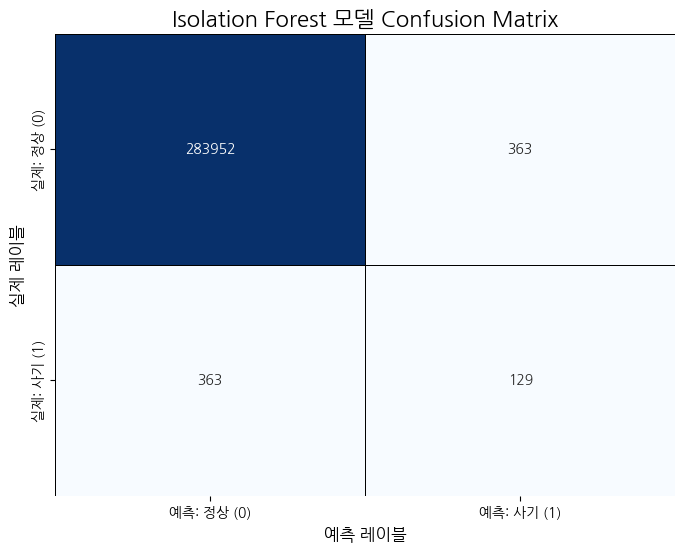


--- Confusion Matrix 상세 분석 ---
True Negative (실제 정상, 예측 정상): 283952 건
False Positive (실제 정상, 예측 사기 - 오탐): 363 건
False Negative (실제 사기, 예측 정상 - 미탐): 363 건
True Positive (실제 사기, 예측 사기 - 정탐): 129 건

Precision (정밀도): 0.26
Recall (재현율): 0.26
F1-Score: 0.26


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd # df를 사용하기 위해 다시 임포트

# --- 한글 폰트 설정 (Colab 전용) ---
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumGothic') # 나눔고딕으로 설정
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지
# -----------------------------------

# (이전 셀에서 X, y, y_pred가 이미 정의되었다고 가정)
# 만약 정의되지 않았다면, 이전 셀의 X, y, y_pred 생성 코드를 여기에 포함해야 합니다.
# 예시:
# X = data.drop('Class', axis=1)
# y = data['Class']
# y_pred = model.predict(X) # model이 이미 학습되어 있다고 가정
# y_pred[y_pred == 1] = 0
# y_pred[y_pred == -1] = 1


# 1. 'Class'별 'Amount' 분포 시각화 (원본 데이터)
# -> 사기 거래가 주로 낮은 금액에서 발생한다는 가설 확인
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', alpha=0.6, label='정상 거래 (Class 0)')
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', alpha=0.6, label='사기 거래 (Class 1)')
plt.title('클래스별 거래 금액 (Amount) 분포', fontsize=16)
plt.xlabel('거래 금액 (Amount)', fontsize=12)
plt.ylabel('거래 건수', fontsize=12)
plt.yscale('log') # 사기 거래가 너무 적어 로그 스케일 적용
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. 'Class'별 'Time' 분포 시각화 (원본 데이터)
# -> 사기 거래가 특정 시간대에 몰리는 경향이 있는지 확인
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Class'] == 0]['Time'], bins=50, color='blue', alpha=0.6, label='정상 거래 (Class 0)')
sns.histplot(df[df['Class'] == 1]['Time'], bins=50, color='red', alpha=0.6, label='사기 거래 (Class 1)')
plt.title('클래스별 거래 시간 (Time) 분포', fontsize=16)
plt.xlabel('거래 시간 (Time)', fontsize=12)
plt.ylabel('거래 건수', fontsize=12)
plt.yscale('log') # 사기 거래가 너무 적어 로그 스케일 적용
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3. 모델 예측 결과 시각화 - Confusion Matrix
# 실제값(y)과 예측값(y_pred)을 바탕으로 혼동 행렬 생성
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['예측: 정상 (0)', '예측: 사기 (1)'],
            yticklabels=['실제: 정상 (0)', '실제: 사기 (1)'],
            linewidths=.5, linecolor='black')
plt.title('Isolation Forest 모델 Confusion Matrix', fontsize=16)
plt.xlabel('예측 레이블', fontsize=12)
plt.ylabel('실제 레이블', fontsize=12)
plt.show()

# 4. Confusion Matrix 상세 값 분석 (텍스트 출력)
tn, fp, fn, tp = cm.ravel()
print("\n--- Confusion Matrix 상세 분석 ---")
print(f"True Negative (실제 정상, 예측 정상): {tn} 건")
print(f"False Positive (실제 정상, 예측 사기 - 오탐): {fp} 건")
print(f"False Negative (실제 사기, 예측 정상 - 미탐): {fn} 건")
print(f"True Positive (실제 사기, 예측 사기 - 정탐): {tp} 건")

# 모델 평가 지표 수동 계산 (참고용)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPrecision (정밀도): {precision:.2f}")
print(f"Recall (재현율): {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

--- 데이터 분할 후 (SMOTE 적용 전) ---
학습 데이터(Train)의 사기 건수: 344 건
테스트 데이터(Test)의 사기 건수: 148 건
테스트 데이터(Test) shape: (85443, 30)

--- SMOTE 적용 시작 (학습 데이터) ---
--- SMOTE 적용 완료 ---
SMOTE 적용 전 (y_train):
Class
0    199020
1       344
Name: count, dtype: int64

SMOTE 적용 후 (y_train_resampled):
Class
0    199020
1    199020
Name: count, dtype: int64
증식된 학습 데이터 (X_train_resampled) shape: (398040, 30)

--- 지도 학습 모델 훈련 시작 ---
훈련 완료!

--- 지도 학습 모델 성능 평가 (테스트셋) ---
실제 사기 건수 (테스트셋): 148 건
모델이 예측한 사기 건수: 134 건

[지도 학습 Classification Report]
                  precision    recall  f1-score   support

Class 0 (Normal)       1.00      1.00      1.00     85295
 Class 1 (Fraud)       0.85      0.77      0.81       148

        accuracy                           1.00     85443
       macro avg       0.93      0.89      0.90     85443
    weighted avg       1.00      1.00      1.00     85443



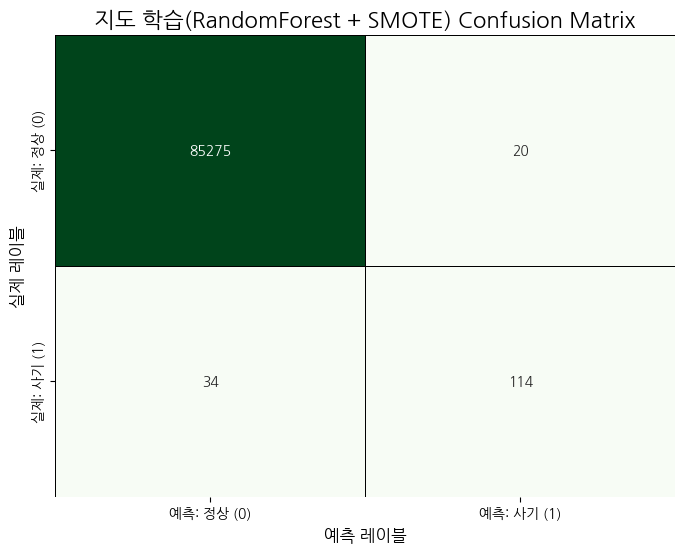

-> fraud_detector_supervised.pkl (지도 학습 모델) 저장 완료!


In [ ]:
# 1. SMOTE를 위한 라이브러리 설치
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# --- 2. 데이터 분리 (Train / Test Split) ---
# (핵심!) 반드시 SMOTE 적용 전에 분리해야 합니다.
# stratify=y : 원본 데이터의 0/1 비율을 유지하면서 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

print("--- 데이터 분할 후 (SMOTE 적용 전) ---")
print(f"학습 데이터(Train)의 사기 건수: {np.sum(y_train)} 건")
print(f"테스트 데이터(Test)의 사기 건수: {np.sum(y_test)} 건")
print(f"테스트 데이터(Test) shape: {X_test.shape}")


# --- 3. SMOTE 오버샘플링 (학습 데이터에만 적용) ---
print("\n--- SMOTE 적용 시작 (학습 데이터) ---")
smote = SMOTE(random_state=42)
# X_train과 y_train에만 fit_resample 적용
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("--- SMOTE 적용 완료 ---")
print("SMOTE 적용 전 (y_train):")
print(pd.Series(y_train).value_counts())
print("\nSMOTE 적용 후 (y_train_resampled):")
print(pd.Series(y_train_resampled).value_counts())
print(f"증식된 학습 데이터 (X_train_resampled) shape: {X_train_resampled.shape}")


# --- 4. 지도 학습 모델 훈련 (RandomForest) ---
# 증식된(균형 잡힌) 학습 데이터로 모델을 훈련시킵니다.
model_supervised = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)

print("\n--- 지도 학습 모델 훈련 시작 ---")
model_supervised.fit(X_train_resampled, y_train_resampled)
print("훈련 완료!")


# --- 5. 모델 평가 (원본 비율의 테스트셋) ---
# 평가는 반드시 SMOTE를 적용하지 않은 '원본' 테스트셋(X_test, y_test)으로 수행합니다.
print("\n--- 지도 학습 모델 성능 평가 (테스트셋) ---")
y_pred_supervised = model_supervised.predict(X_test)

print(f"실제 사기 건수 (테스트셋): {np.sum(y_test)} 건")
print(f"모델이 예측한 사기 건수: {np.sum(y_pred_supervised)} 건")

# Classification Report 출력
print("\n[지도 학습 Classification Report]")
print(classification_report(y_test, y_pred_supervised, target_names=['Class 0 (Normal)', 'Class 1 (Fraud)']))

# Confusion Matrix 시각화 (한글 폰트 설정은 이전 셀에서 완료되었다고 가정)
cm_supervised = confusion_matrix(y_test, y_pred_supervised)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_supervised, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['예측: 정상 (0)', '예측: 사기 (1)'],
            yticklabels=['실제: 정상 (0)', '실제: 사기 (1)'],
            linewidths=.5, linecolor='black')
plt.title('지도 학습(RandomForest + SMOTE) Confusion Matrix', fontsize=16)
plt.xlabel('예측 레이블', fontsize=12)
plt.ylabel('실제 레이블', fontsize=12)
plt.show()

# (참고) 이 모델도 저장
import joblib
joblib.dump(model_supervised, 'fraud_detector_supervised.pkl')
print("-> fraud_detector_supervised.pkl (지도 학습 모델) 저장 완료!")

https://docs.google.com/document/d/1utmgC0rAR6gC9ILzHgCfR4xpFoQVUqjzOfj5jgOTEo8/edit?usp=sharing
- 26% 성능에서 recall을 77% 까지 올린거에 대한 보고서